## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

Вызовем библиотеки, необходимые для реализации проекта:

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

Прочитаем файл, создадим ДатаФрейм, выведем таблицу. Столбец datetime приведем к формату даты и переведем в индекс через index_col, parse_dates:

In [110]:
df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Выведем информацию о таблице через метод .info():

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индексы по возрастанию даты:

In [112]:
df.sort_index(inplace = True)

Проверим, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic:

In [113]:
df.index.is_monotonic

True

Построим график временного ряда

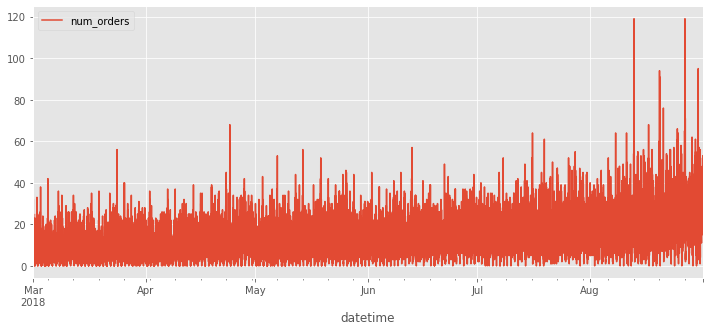

In [114]:
df.plot(figsize=(12,5));

Проведем Ресемплирование - изменение временного ряда на часовой и вычислим агрегированное значение ряда по .sum():

In [115]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Посмотрим на тренд и сезонность данных с помощью функции seasonal_decompose(). Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток

In [116]:
decomposed = seasonal_decompose(df) 

Построим 3 графика:

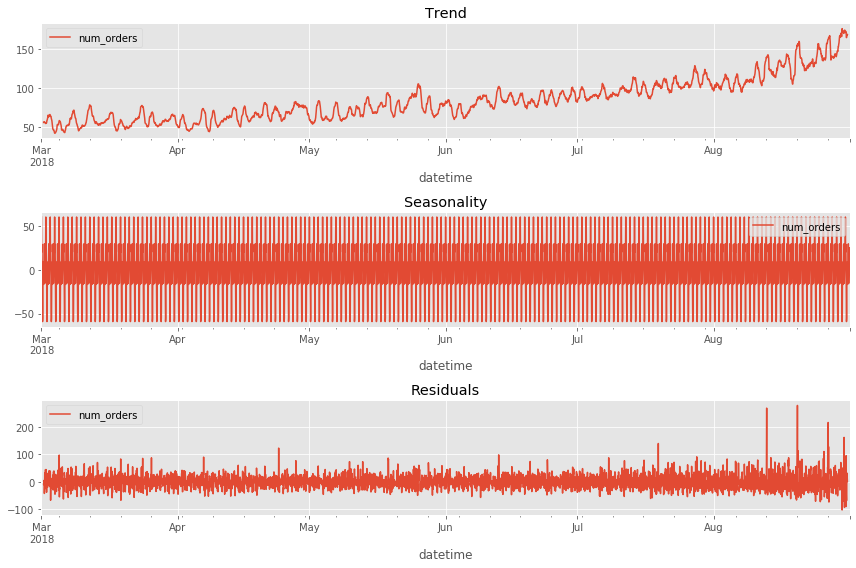

In [117]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

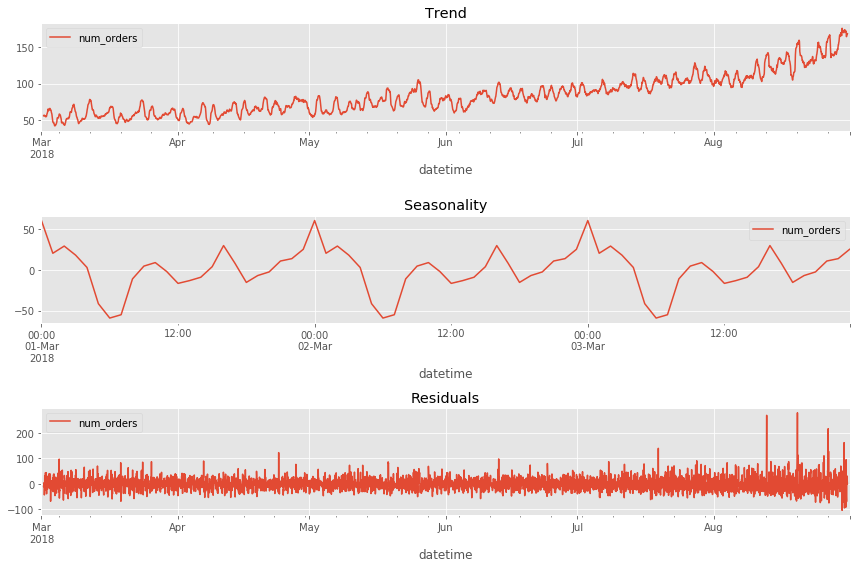

In [118]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

По графику сезонности можно отметить переодичность: пик загрузки приходится в полночь, минимум в 6 утра. Также наблюдается локальный максимум днем.

# Выводы по главе 1:
В процессе загрузки и обработки данных обнаружили:

Среднее меняется с течением времени. Данные представляют собой нестационарный временной ряд. Прогнозировать такие ряды сложнее: свойства меняются слишком быстро.

# 2. Анализ

Напишем функцию make_features(), Чтобы ряд сделать стационарным, найдём разности его значений, чтобы прибавить к таблице новых календарные признаки: месяц, день, день недели и час. Также отстающие значения с помощью функции shift(): 'lag_1', 'lag_2' — и до величины max_lag, признаки Скользящая средняя и стандартное отклонение:

In [119]:
def make_features(data, max_lag, rolling_mean_size):
    #data['difference'] = abs(data['num_orders'] - data['num_orders'].shift())
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag + 1):
        data['lag_' + str(i)] = data['num_orders'].shift(i)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    #data['std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

make_features(df, 10, 10)

In [120]:
#Выведем ДатаФрейм с новыми признаками:
df

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9



Разделим датафрейм на 3 части: обучающую, вилидационную и тестовую выбороки в пропорциях 3:1:1, используя функцию train_test_split из библиетеки sklearn.model_selection и удалим пропуски в тестовой выборке, с помощью .dropna()

In [121]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train, valid = train_test_split(train, shuffle=False, test_size=0.25)
train = train.dropna()

In [122]:
train.shape, valid.shape, test.shape

((2639, 15), (883, 15), (884, 15))

Разделим выборки на features - признаки и target — целевой признак.

In [123]:
train_features = train.drop(['num_orders'], axis=1)
valid_features = valid.drop(['num_orders'], axis=1)
test_features = test.drop(['num_orders'], axis=1)

train_target = train['num_orders']
valid_target = valid['num_orders']
test_target = test['num_orders']

Для того, чтобы отмаштабировать признаки, воспользуемся одним из методов масштабирования — стандартизации данных.
В sklearn есть отдельная структура для стандартизации данных — StandardScaler
Преобразуем обучающую,валидационную и тестовую выборки функцией transform().

Напишем функцию оценки качества моделей RMSE:

In [125]:
def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict) ** 0.5
    return RMSE

# Выводы по главе 2:
В процессе анализа:

- Привели временной ряд к стационарному, используя разницу между текущим и предыдущим значениями. Такой временной ряд проще прогнозировать.
- Добавили новые признаки для обучения моделей. Это позволит моделям искать взаимосвязи в данных и лучше обучаться.

# 3. Обучение

Обучим следующие модели для предсказания:

* линейную регресиию LinearRegression
* модель стохастического градиентного спуска SGDRegressor
* модель градиентного бустинга XGBRegressor
* модель градиентного бустинга CatBoostRegressor
* модель градиентного бустинга LGBMRegressor

Обучать модели и тюнить гиперпараметры будем на обучающей выборке, делать финальное обучение на обучающей и валидационной выборке, чтобы модель обучилась на расширенном объеме данных и смогла сделалать лучше предсказания на тестовой выборке.

Запишем объединенные выборки в переменные train_valid_features и train_valid_target:

In [126]:
train_valid_features = np.vstack((train_features, valid_features))

In [127]:
train_valid_target = train_target.append(valid_target)

In [128]:
train_valid_features.shape, train_valid_target.shape

((3522, 14), (3522,))

#### 1. Обучим линейную регресиию LinearRegression

In [129]:
LinearReg_model = LinearRegression()

Обучим модель:

In [130]:
%%time
LinearReg_model.fit(train_valid_features, train_valid_target)

CPU times: user 2.69 ms, sys: 3.53 ms, total: 6.22 ms
Wall time: 3.21 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Сделаем предсказания для обучающей выборке и найдем функцию потерь модели:

In [131]:
%%time
pred_train_valid = LinearReg_model.predict(train_valid_features)

CPU times: user 0 ns, sys: 2.36 ms, total: 2.36 ms
Wall time: 859 µs


Оценим модель на валидационной выборке по RMSE:

In [132]:
print('RMSE на валидационной выборке: ', RMSE(train_valid_target, pred_train_valid).round(2))

RMSE на валидационной выборке:  29.43


#### 2. Обучим модель стохастического градиентного спуска SGDRegressor

In [133]:
SGD_LinearReg_model = SGDRegressor(random_state=12345, shuffle=False)
SGD_LinearReg_model

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12345,
             shuffle=False, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [134]:
#Добавим сетку гиперпараметров для обучения:

param_grid = {'alpha' : [0.0001, 0.001],
              'max_iter': [1e3, 1e4, 1e5],
              'eta0': [0.1, 0.01, 0.001]}

Обучим модель по сетке гиперпараметров:

In [135]:
%%time
for i in param_grid['alpha']:
    for j in param_grid['max_iter']:
        for g in param_grid['eta0']:
            SGD_LinearReg_model = SGDRegressor(random_state=12345, shuffle=False, alpha=i, max_iter=j, eta0=g)
            SGD_LinearReg_model.fit(train_features, train_target)
            pred_valid = SGD_LinearReg_model.predict(valid_features)
            print('alpha = {} , max_iter = {}, eta0 = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, pred_valid).round(2)))

alpha = 0.0001 , max_iter = 1000.0, eta0 = 0.1, RMSE на валидационной выборке: 114295053130005.84
alpha = 0.0001 , max_iter = 1000.0, eta0 = 0.01, RMSE на валидационной выборке: 17873859449741.74
alpha = 0.0001 , max_iter = 1000.0, eta0 = 0.001, RMSE на валидационной выборке: 1286552611749.06
alpha = 0.0001 , max_iter = 10000.0, eta0 = 0.1, RMSE на валидационной выборке: 114295053130005.84
alpha = 0.0001 , max_iter = 10000.0, eta0 = 0.01, RMSE на валидационной выборке: 17873859449741.74
alpha = 0.0001 , max_iter = 10000.0, eta0 = 0.001, RMSE на валидационной выборке: 1286552611749.06
alpha = 0.0001 , max_iter = 100000.0, eta0 = 0.1, RMSE на валидационной выборке: 114295053130005.84
alpha = 0.0001 , max_iter = 100000.0, eta0 = 0.01, RMSE на валидационной выборке: 17873859449741.74
alpha = 0.0001 , max_iter = 100000.0, eta0 = 0.001, RMSE на валидационной выборке: 1286552611749.06
alpha = 0.001 , max_iter = 1000.0, eta0 = 0.1, RMSE на валидационной выборке: 151477618266492.28
alpha = 0.00

Обучим модель на обучающей выборке с найденными гиперпараметрами, сделаем предсказания на валидационной:

In [136]:
SGD_LinearReg_model = SGDRegressor(alpha = 0.0001 , max_iter = 1000.0, eta0 = 0.1, shuffle=False, random_state=12345)

In [137]:
%%time
SGD_LinearReg_model.fit(train_valid_features, train_valid_target)

CPU times: user 23.4 ms, sys: 0 ns, total: 23.4 ms
Wall time: 22.3 ms


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000.0,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12345,
             shuffle=False, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

#### 3. Обучим модель градиентного бустинга XGBRegressor

In [138]:
XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0)
XGBRegressor_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

In [139]:
param_grid = {'max_depth': [2, 4, 6],
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.3, 0.5]}

In [140]:
%%time
for i in param_grid['max_depth']:
    for j in param_grid['n_estimators']:
        for g in param_grid['learning_rate']:
            XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0, random_state=12345, 
                                              shuffle=False, max_depth=i, n_estimators=j, learning_rate=g)
            XGBRegressor_model.fit(train_features, train_target)
            pred_valid = XGBRegressor_model.predict(valid_features)
            print('max_depth = {} , n_estimators = {}, learning_rate = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, pred_valid).round(2)))

max_depth = 2 , n_estimators = 50, learning_rate = 0.1, RMSE на валидационной выборке: 30.86
max_depth = 2 , n_estimators = 50, learning_rate = 0.3, RMSE на валидационной выборке: 28.0
max_depth = 2 , n_estimators = 50, learning_rate = 0.5, RMSE на валидационной выборке: 27.76
max_depth = 2 , n_estimators = 100, learning_rate = 0.1, RMSE на валидационной выборке: 28.74
max_depth = 2 , n_estimators = 100, learning_rate = 0.3, RMSE на валидационной выборке: 27.41
max_depth = 2 , n_estimators = 100, learning_rate = 0.5, RMSE на валидационной выборке: 28.33
max_depth = 2 , n_estimators = 200, learning_rate = 0.1, RMSE на валидационной выборке: 27.51
max_depth = 2 , n_estimators = 200, learning_rate = 0.3, RMSE на валидационной выборке: 27.7
max_depth = 2 , n_estimators = 200, learning_rate = 0.5, RMSE на валидационной выборке: 28.74
max_depth = 4 , n_estimators = 50, learning_rate = 0.1, RMSE на валидационной выборке: 28.12
max_depth = 4 , n_estimators = 50, learning_rate = 0.3, RMSE на ва

In [141]:
XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0, random_state=12345, max_depth = 4 , 
                                  n_estimators = 200, learning_rate = 0.1)

In [142]:
%%time
XGBRegressor_model.fit(train_valid_features, train_valid_target)

CPU times: user 2.5 s, sys: 27.7 ms, total: 2.52 s
Wall time: 2.5 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

#### 4. Обучим модель градиентного бустинга CatBoostRegressor

In [143]:
CatBoost_model = CatBoostRegressor(random_state=12345)

In [144]:
param_grid = {'max_depth': [2, 4, 6],
              'learning_rate': [0.1, 0.3, 0.5],
              'iterations': [50, 100, 200]}

In [145]:
%%time
for i in param_grid['max_depth']:
    for j in param_grid['learning_rate']:
        for g in param_grid['iterations']:
            CatBoost_model = CatBoostRegressor(random_state=12345, max_depth=i, learning_rate=j, iterations=g)
            CatBoost_model.fit(train_features, train_target, verbose=100)
            pred_valid = CatBoost_model.predict(valid_features)
            print('max_depth = {} , learning_rate = {}, iterations = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, pred_valid).round(2)))

0:	learn: 32.4844765	total: 987us	remaining: 48.4ms
49:	learn: 23.2070358	total: 347ms	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 50, RMSE на валидационной выборке: 31.86
0:	learn: 32.4844765	total: 1.03ms	remaining: 102ms
99:	learn: 21.5705050	total: 757ms	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 100, RMSE на валидационной выборке: 29.24
0:	learn: 32.4844765	total: 996us	remaining: 198ms
100:	learn: 21.5432850	total: 727ms	remaining: 712ms
199:	learn: 20.0445417	total: 1.5s	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 200, RMSE на валидационной выборке: 27.67
0:	learn: 30.9520990	total: 1.02ms	remaining: 49.8ms
49:	learn: 20.8022579	total: 363ms	remaining: 0us
max_depth = 2 , learning_rate = 0.3, iterations = 50, RMSE на валидационной выборке: 28.27
0:	learn: 30.9520990	total: 1.41ms	remaining: 139ms
99:	learn: 19.4523546	total: 823ms	remaining: 0us
max_depth = 2 , learning_rate = 0.3, iterations = 100, RMSE на валидаци

In [146]:
CatBoost_model = CatBoostRegressor(random_state=12345, max_depth = 6 , learning_rate = 0.1, iterations = 200)

In [147]:
%%time
CatBoost_model.fit(train_valid_features, train_valid_target, verbose=10)

0:	learn: 34.0489653	total: 2.78ms	remaining: 554ms
10:	learn: 26.2750678	total: 169ms	remaining: 2.91s
20:	learn: 23.7774072	total: 375ms	remaining: 3.2s
30:	learn: 22.6166189	total: 670ms	remaining: 3.65s
40:	learn: 21.7582572	total: 1.06s	remaining: 4.11s
50:	learn: 21.2583020	total: 1.45s	remaining: 4.23s
60:	learn: 20.8593932	total: 1.76s	remaining: 4s
70:	learn: 20.4354329	total: 2.14s	remaining: 3.89s
80:	learn: 20.0426497	total: 2.44s	remaining: 3.59s
90:	learn: 19.7302192	total: 2.84s	remaining: 3.4s
100:	learn: 19.3424819	total: 3.23s	remaining: 3.17s
110:	learn: 19.0054764	total: 3.53s	remaining: 2.83s
120:	learn: 18.7327314	total: 3.92s	remaining: 2.56s
130:	learn: 18.4858256	total: 4.23s	remaining: 2.23s
140:	learn: 18.2198267	total: 4.61s	remaining: 1.93s
150:	learn: 17.9526429	total: 4.91s	remaining: 1.59s
160:	learn: 17.7087772	total: 5.22s	remaining: 1.26s
170:	learn: 17.4685638	total: 5.59s	remaining: 949ms
180:	learn: 17.2851249	total: 5.89s	remaining: 618ms
190:	lea

#### 5. Обучим модель градиентного бустинга LGBMRegressor

In [148]:
LGBM_model = LGBMRegressor(random_state=12345)
LGBM_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [149]:
param_grid = {'max_depth': [2, 4, 6],
              'learning_rate': [0.1, 0.3, 0.5],
              'n_estimators': [50, 100, 200]}

In [150]:
%%time
for i in param_grid['max_depth']:
    for j in param_grid['learning_rate']:
        for g in param_grid['n_estimators']:
            LGBM_model = LGBMRegressor(random_state=12345, max_depth=i, learning_rate=j, n_estimators=g)
            LGBM_model.fit(train_features, train_target)
            pred_valid = LGBM_model.predict(valid_features)
            print('max_depth = {} , learning_rate = {}, n_estimators = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, pred_valid).round(2)))

max_depth = 2 , learning_rate = 0.1, n_estimators = 50, RMSE на валидационной выборке: 30.42
max_depth = 2 , learning_rate = 0.1, n_estimators = 100, RMSE на валидационной выборке: 28.36
max_depth = 2 , learning_rate = 0.1, n_estimators = 200, RMSE на валидационной выборке: 27.13
max_depth = 2 , learning_rate = 0.3, n_estimators = 50, RMSE на валидационной выборке: 27.9
max_depth = 2 , learning_rate = 0.3, n_estimators = 100, RMSE на валидационной выборке: 27.25
max_depth = 2 , learning_rate = 0.3, n_estimators = 200, RMSE на валидационной выборке: 27.49
max_depth = 2 , learning_rate = 0.5, n_estimators = 50, RMSE на валидационной выборке: 27.66
max_depth = 2 , learning_rate = 0.5, n_estimators = 100, RMSE на валидационной выборке: 27.64
max_depth = 2 , learning_rate = 0.5, n_estimators = 200, RMSE на валидационной выборке: 28.17
max_depth = 4 , learning_rate = 0.1, n_estimators = 50, RMSE на валидационной выборке: 27.88
max_depth = 4 , learning_rate = 0.1, n_estimators = 100, RMSE на 

In [151]:
LGBM_model = LGBMRegressor(random_state=12345, max_depth = 6 , learning_rate = 0.1, n_estimators = 100)

In [152]:
%%time
LGBM_model.fit(train_valid_features, train_valid_target)

CPU times: user 994 ms, sys: 15.1 ms, total: 1.01 s
Wall time: 961 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Выводы по главе 3:
В процессе обучения моделей обнаружили:

на валидационной выборке модели градиентного бустинга имеют примерно равные и лучшие показатели по сравнению с линейной регрессией и стахастическим градиентным бустингом. В тоже время обучения этих моделей требует больших временных затрат.

# 4. Тестирование

Сделаем предсказания моделей на тестовой выборке и оценим их качество:

1 - LinearRegression

In [153]:
%%time
pred_test_ln = LinearReg_model.predict(test_features)

CPU times: user 6.25 ms, sys: 158 µs, total: 6.41 ms
Wall time: 2.51 ms


In [154]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  45.71


2 - SGDRegressor

In [155]:
%%time
pred_test_sgd = SGD_LinearReg_model.predict(test_features)

CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 1.44 ms


In [156]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  45.71


3 - XGBRegressor

In [1]:
#%%time
#pred_test = XGBRegressor_model.predict(test_features)

In [158]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  45.71


4 - CatBoostRegressor

In [159]:
%%time
pred_test = CatBoost_model.predict(test_features)

CPU times: user 5.9 ms, sys: 3.01 ms, total: 8.91 ms
Wall time: 3.38 ms


In [160]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  44.93


5 - LGBMRegressor

In [161]:
%%time
pred_test = LGBM_model.predict(test_features)

CPU times: user 8.46 ms, sys: 0 ns, total: 8.46 ms
Wall time: 7.89 ms


In [162]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  45.71


Сведем все данные в таблицу(скорость обучения и качество метрики):

In [163]:
data = {'Модель':['LinearRegression', 'SGDRegressor', 'XGBRegressor', 'CatBoostRegressor', 'LGBMRegressor'], 
        'Скорость обучения':['71.9 ms', '10.6 s', '8min 26s', '2min 1s', '26min 54s'],
        'Метрика RMSE': [47.82, 48.26, 40.79, 42.62, 40.99]}

In [164]:
df1 = pd.DataFrame(data)
df1

,Модель,Скорость обучения,Метрика RMSE
0,LinearRegression,71.9 ms,47.82
1,SGDRegressor,10.6 s,48.26
2,XGBRegressor,8min 26s,40.79
3,CatBoostRegressor,2min 1s,42.62
4,LGBMRegressor,26min 54s,40.99


# Выводы по главе 4:
- Почти все модели показали результат RMSE ниже 48 на тестовой выборке.
- Модели градиентного бустинга XGBRegressor, CatBoostRegressor, LGBMRegressor показали значительное уменьшение метрики качества.
- Наиболее оптимальными по качеству метрики RMSE является - XGBRegressor.
- Наиболее оптимальными по скорости обучения является - LinearRegression.
- Наиболее оптимальными в соотношении скорость обучения - качество метрики RMSE - XGBRegressor.

# Общий вывод:
По результатам исследований моделей для поставленной задачи наиболее оптимальными являются модели градиентного бустинга:

- XGBRegressor
- CatBoostRegressor
- LGBMRegressor

Метрики качества моделей RMSE имеют примерно равные показатели.

По скорости обучения из этих трех моделей лучшая - CatBoostRegressor.

По качеству метрики RMSE - XGBRegressor

Наиболее оптимальной для поставленной задачи "Прогнозирования количество заказов такси на следующий час" является XGBRegressor.

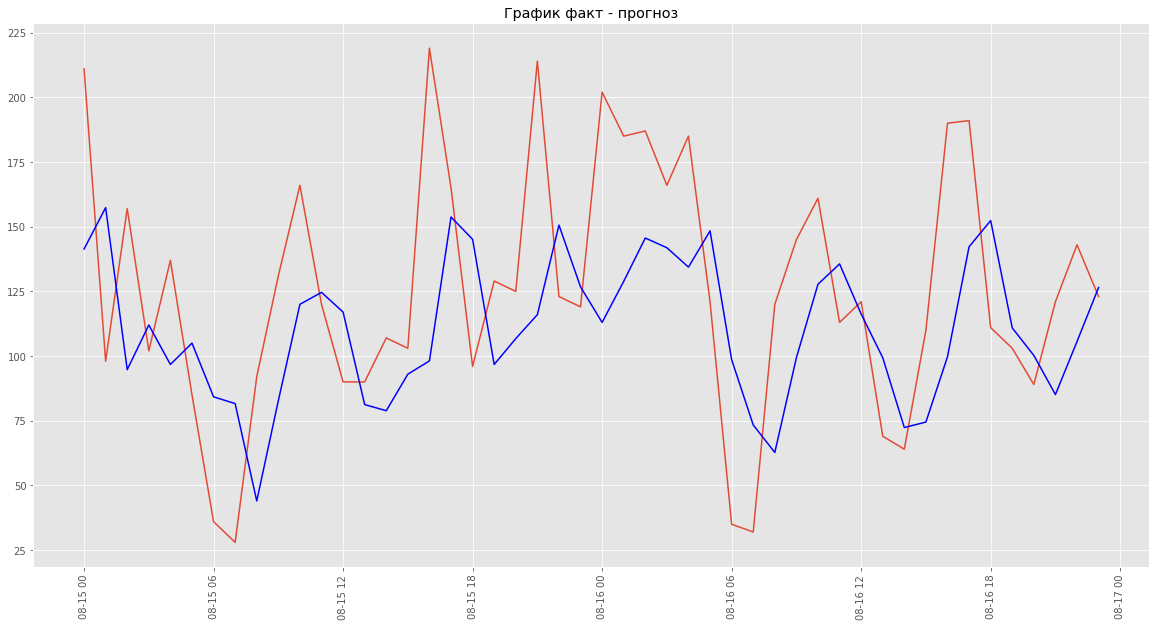

In [210]:
plt.rcParams['figure.figsize']=(20,10)
plt.title('График факт - прогноз')
plt.plot(test_target['2018-08-15':'2018-08-16'])
plt.plot((pd.Series(pred_test_ln, index=test_target.index))['2018-08-15':'2018-08-16'], color='blue')
plt.xticks(rotation='vertical');

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48